In [1]:
import torch, math
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from nets import Qnetn, MLP_NN
from taskmeta import SINTASK, SINTASK2, SINTASK3, SIN_xlow, SIN_xhigh


device, dtype = 'cpu', torch.float32
def tensor(data, rgrad=False):
    return torch.tensor(data, device=device, dtype=dtype, requires_grad=rgrad)

GRS = 12
RNG = np.random.default_rng(GRS)
randseed = lambda : RNG.integers(1, 10_000)
xl, xh = SIN_xlow, SIN_xhigh

HH = [1, 25, 25, 25, 1]
lossF = lambda pp, yy: 0.5 * (pp-yy)**2
lossM = lambda pp, yy: torch.sum(0.5 * (pp - yy) ** 2) 

NN = lambda : MLP_NN(HH, device, dtype, actF=nn.ReLU, seed=randseed())
NP = lambda ext_params: MLP_NN(ext_params, device, dtype, actF=nn.ReLU, seed=randseed(), from_param=True)

# Meta Learning

Using Reptile approach

In [2]:
taskerL = [
    SINTASK2((7, 3), seed=randseed()),
    SINTASK2((6, 2), seed=randseed()),
    SINTASK2((5, 1), seed=randseed()),
    SINTASK2((4, 0), seed=randseed()),
    SINTASK2((3, -1), seed=randseed()),
] 

# algorithm

In [3]:
outer_epochs =  5000
outer_lr =      0.01
inner_epochs = 1000
inner_lr =      0.001
task_batch_size =    5
train_K =       8
test_K =        8
P = print

# training

# 1: randomly initialize theta 
--------------------------
~ N_LAYERS:[4]
~ D_TYPE:[torch.float32]
~ DEV:[cpu]
--------------------------
--> Weights[0]:: Params[25] of Shape[torch.Size([25, 1])]
 ~--> [PARAMETER TENSOR]: tensor([[ 4.0752e-02],
        [-8.0139e-02],
        [-2.0934e-03],
        [ 9.1835e-02],
        [-6.5284e-05],
        [ 5.8189e-02],
        [-8.6809e-02],
        [ 2.3397e-02],
        [ 6.8264e-02],
        [-1.3586e-02],
        [ 2.6145e-02],
        [-1.7595e-02],
        [ 3.8888e-02],
        [-8.4653e-02],
        [ 2.8353e-02],
        [-5.0440e-02],
        [-5.0463e-02],
        [-2.3697e-02],
        [-6.8030e-02],
        [-3.7875e-02],
        [-2.6412e-02],
        [ 5.6413e-04],
        [-8.0990e-02],
        [-4.2174e-03],
        [-5.4436e-02]], requires_grad=True)
--> Bias[0]:: Params[25] of Shape[torch.Size([25])]
 ~--> [PARAMETER TENSOR]: tensor([-0.0140, -0.0385,  0.0818, -0.0299, -0.0257,  0.0169, -0.0935,  0.0139,
         0.0154,  0.0660

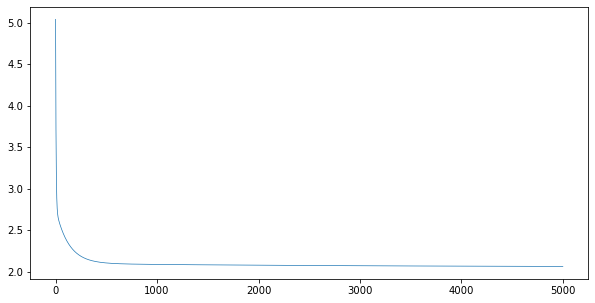

In [4]:
P('# 1: randomly initialize theta ')
theta = NN()
theta.info( show_vals=True, P=P)

#P('# 2: while not done ', outer_epochs )
#for outer_epoch in range(outer_epochs):

# 3: sample a batch of taskss
task_batch = [ taskerL[i%len(taskerL)] for i in range(task_batch_size) ]
P('# 3: sampled task batch: -({})-'.format(task_batch))

#P('# 4: for each task do')
thetaL = []
for tasker in task_batch:

    # Repeate till converged
    theta_task = NN()

    for inner_epoch in range(inner_epochs):
        #P('# 5: sample train_K data points', train_K)
        train_db =tasker.sample(train_K)
        batch_x = torch.tensor(np.expand_dims(train_db[ :, 0 ],axis=-1), dtype=torch.float32)
        batch_y = torch.tensor(np.expand_dims(train_db[ :, 1 ],axis=-1), dtype=torch.float32)

        #P('# 6: evaluate grad_theta(loss)')
        # theta.zero_grad()
        pred = theta_task.forward(batch_x)
        loss =  lossM(pred, batch_y) #torch.sum((pred - batch_y) ** 2) 
        #P('\t Loss:', loss.item())
        #loss.backward(create_graph=True)
        grads = torch.autograd.grad(loss, theta_task.parameters, create_graph=False)

        #P('# 7: compute adapted paramters with grad descent')
        with torch.no_grad():
            for t_param, grad in zip(theta_task.parameters, grads):
                t_param -= inner_lr * grad
        theta_task.zero_grad()

    thetaL.append(theta_task)

#P('# 9: end for (tasker)')

diff_hist=[]
P('# 10: meta update')
# find the difference vector
for outer_epoch in range(outer_epochs):
    theta.zero_grad()
    diff_stack = []
    for Ti in thetaL:
        diff_i = []
        for ti,th in zip(Ti.parameters, theta.parameters):
            diff_i.append(torch.mean((ti-th)**2))
        #diff_i_tensor = torch.stack(diff_i)
        diff_stack.append(torch.sum(torch.stack(diff_i)))
    diff_tensors = torch.sum(torch.stack(diff_stack))
    
    diff_hist.append(diff_tensors.item())
    P('\t Diff:', diff_hist[-1])

    ograds = torch.autograd.grad(diff_tensors, theta.parameters, create_graph=False)
    #P('... update outer params')
    with torch.no_grad():
        #grad_sum = torch.sum(ograds)
        #P('Outer-Grads:', grad_sum.item())
        for t_param, grad in zip(theta.parameters, ograds):
            #print( 'grad-shapes', t_param , grad )
            t_param -= outer_lr * grad
            #print( 'After', t_param )

P('# 11: end for')
plt.figure('diff_hist', figsize=(10,5))
plt.plot(diff_hist, linewidth=0.7)
plt.show()

In [5]:

theta.save_external('reptile_pie')
theta.info()

--------------------------
~ N_LAYERS:[4]
~ D_TYPE:[torch.float32]
~ DEV:[cpu]
--------------------------
--> Weights[0]:: Params[25] of Shape[torch.Size([25, 1])]
--> Bias[0]:: Params[25] of Shape[torch.Size([25])]
--> Weights[1]:: Params[625] of Shape[torch.Size([25, 25])]
--> Bias[1]:: Params[25] of Shape[torch.Size([25])]
--> Weights[2]:: Params[625] of Shape[torch.Size([25, 25])]
--> Bias[2]:: Params[25] of Shape[torch.Size([25])]
--> Weights[3]:: Params[25] of Shape[torch.Size([1, 25])]
--> Bias[3]:: Params[1] of Shape[torch.Size([1])]
--------------------------
PARAMS:	 1,376
--------------------------


1376

In [6]:
theta.info(show_vals=True)

--------------------------
~ N_LAYERS:[4]
~ D_TYPE:[torch.float32]
~ DEV:[cpu]
--------------------------
--> Weights[0]:: Params[25] of Shape[torch.Size([25, 1])]
 ~--> [PARAMETER TENSOR]: tensor([[ 0.0099],
        [ 0.0434],
        [ 0.1610],
        [ 0.2345],
        [ 0.0178],
        [ 0.0938],
        [ 0.0936],
        [ 0.1359],
        [ 0.1680],
        [-0.0072],
        [ 0.2056],
        [ 0.0312],
        [ 0.1123],
        [ 0.0720],
        [ 0.1384],
        [ 0.2024],
        [ 0.2462],
        [ 0.1701],
        [ 0.0190],
        [ 0.0618],
        [-0.0532],
        [ 0.0220],
        [ 0.1187],
        [ 0.1102],
        [ 0.0225]], requires_grad=True)
--> Bias[0]:: Params[25] of Shape[torch.Size([25])]
 ~--> [PARAMETER TENSOR]: tensor([-0.0747, -0.0545, -0.0731, -0.1734,  0.0592, -0.1887, -0.1400, -0.2720,
        -0.2188, -0.1112, -0.0990, -0.0431, -0.0077, -0.0298,  0.0145, -0.1477,
        -0.1332, -0.1129, -0.0199, -0.1560,  0.2042,  0.0219, -0.0395, -0.08

1376